In [596]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import numpy as np
from limix.plot import qqplot
import warnings
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import gzip
import pandas as pd

mean_features = {}
with h5py.File(GTEx_directory + '/data/intermediate/new_retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    donor_IDs = f['lung']['256']['donor_IDs'].value
    for s in ['128','256','512','1024','2048']:
        size_mean_features = f['lung'][s]['mean'].value
        mean_features[s] = size_mean_features
        
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))

filt_expression = expression[:,most_expressed_transcript_idx]
filt_features = mean_features['256'][:,most_varying_feature_idx]

phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
with gzip.open(phenotype_filepath, 'rb') as f:
    phenotype_array = [str(x, 'utf-8').split('\t') for x in f.read().splitlines() if not str(x, 'utf-8').startswith('#')][1:]
    phenotype_df = pd.DataFrame(phenotype_array)
    phenotype_df.columns = phenotype_df.iloc[0]
    phenotype_df = phenotype_df[1:]

lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
phenotype_idx = [[x.split('-')[1] for x in lung_df['SAMPID']].index(ID) for ID in [x.decode('utf-8').split('-')[1] for x in donor_IDs]]


lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
lung_df = lung_df.iloc[phenotype_idx,:]

filt_tech_expression =  filt_expression[technical_idx,:]
filt_tech_features =  filt_features[technical_idx,:]
print ("Filtered technical features:")
print (filt_tech_expression.shape, filt_tech_features.shape)

Filtered technical features:
(231, 200) (231, 100)


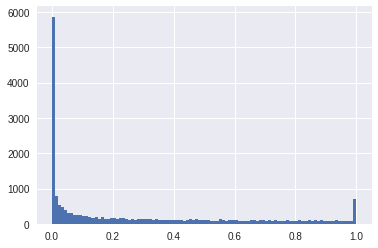

In [780]:
plt.hist(results['mean_256_pvalues'].flatten(),bins=100)
plt.show()

This results in 76 covariates for each of the 274 lung samples.

We define our function to again estimate the inflation parameter, $\lambda$.

In [597]:
import scipy.stats as st
import scipy as sp
def estimate_lambda(pv):
    """estimate lambda form a set of PV"""
    LOD2 = sp.median(st.chi2.isf(pv, 1))
    null_median = st.chi2.median(1)
    L = (LOD2 / null_median)
    return (L)

We take only the samples for which we have technical factors. 

In [598]:
clean_lung_df = pd.DataFrame()
for col in lung_df.columns:
    clean_factor = pd.to_numeric(lung_df[col],errors='coerce')
    clean_lung_df[col] = clean_factor
    

clean_lung_df = clean_lung_df.dropna(how='all',axis=1)
technical_idx = np.array(clean_lung_df.isnull().sum(axis=1) == 0)
clean_lung_df = clean_lung_df.dropna(how='any',axis=0)
raw_technical_covariates = np.array(clean_lung_df)
filter_technical_cov_idx = np.std(raw_technical_covariates,axis=0) < 100
raw_technical_covariates = raw_technical_covariates[:,filter_technical_cov_idx]

This results in a total of 231 samples. We also ensure that we take technical factors with limited variance (< 100), this results in 29 continuous technical factors.

In [599]:
print ("Raw features:")
print (mean_features['256'].shape, expression.shape)
print ("Filtered features:")
print (filt_expression.shape, filt_features.shape)
print ("Technical factors:")
print (raw_technical_covariates.shape)

Raw features:
(274, 1024) (274, 28683)
Filtered features:
(274, 200) (274, 100)
Technical factors:
(231, 29)


Here are the names of the different technical factors we have included. Here are some example descriptions:
* SMATSSCR: Autolysis score
* SMRIN: RNA degradation (RIN) number
* SMTSISCH: Ischemic time

In [578]:
clean_lung_df.columns

Index(['dbGaP_Sample_ID', 'SMATSSCR', 'SMRIN', 'SMUBRID', 'SMTSISCH',
       'SMTSPAX', 'SME2MPRT', 'SMCHMPRS', 'SMNTRART', 'SMNUMGPS', 'SMMAPRT',
       'SMEXNCRT', 'SM550NRM', 'SMGNSDTC', 'SMUNMPRT', 'SM350NRM', 'SMRDLGTH',
       'SMMNCPB', 'SME1MMRT', 'SMSFLGTH', 'SMESTLBS', 'SMMPPD', 'SMNTERRT',
       'SMRRNANM', 'SMRDTTL', 'SMVQCFL', 'SMMNCV', 'SMTRSCPT', 'SMMPPDPR',
       'SMCGLGTH', 'SMGAPPCT', 'SMUNPDRD', 'SMNTRNRT', 'SMMPUNRT', 'SMEXPEFF',
       'SMMPPDUN', 'SME2MMRT', 'SME2ANTI', 'SMALTALG', 'SME2SNSE', 'SMMFLGTH',
       'SME1ANTI', 'SMSPLTRD', 'SMBSMMRT', 'SME1SNSE', 'SME1PCTS', 'SMRRNART',
       'SME1MPRT', 'SMNUM5CD', 'SMDPMPRT', 'SME2PCTS'],
      dtype='object')

This histogram shows the standard deviations of the technical covariates we have chosen to look at. Note that there are technical factors that still vary a great deal.

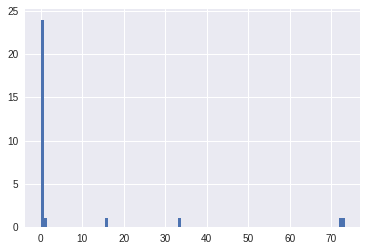

In [580]:
plt.hist(raw_technical_covariates.std(axis=0),bins=100)
plt.show()

Take the first 20 PCs of the expression matrix.

We would like to investigate how including these known technical covariates impact the analysis. 

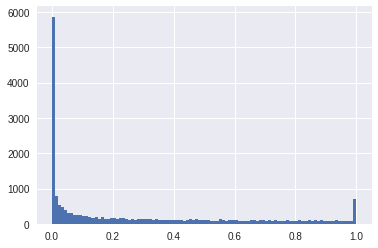

In [780]:
plt.hist(results['mean_256_pvalues'].flatten(),bins=100)
plt.show()

This results in 76 covariates for each of the 274 lung samples.

We define our function to again estimate the inflation parameter, $\lambda$.

In [597]:
import scipy.stats as st
import scipy as sp
def estimate_lambda(pv):
    """estimate lambda form a set of PV"""
    LOD2 = sp.median(st.chi2.isf(pv, 1))
    null_median = st.chi2.median(1)
    L = (LOD2 / null_median)
    return (L)

We take only the samples for which we have technical factors. 

In [598]:
clean_lung_df = pd.DataFrame()
for col in lung_df.columns:
    clean_factor = pd.to_numeric(lung_df[col],errors='coerce')
    clean_lung_df[col] = clean_factor
    

clean_lung_df = clean_lung_df.dropna(how='all',axis=1)
technical_idx = np.array(clean_lung_df.isnull().sum(axis=1) == 0)
clean_lung_df = clean_lung_df.dropna(how='any',axis=0)
raw_technical_covariates = np.array(clean_lung_df)
filter_technical_cov_idx = np.std(raw_technical_covariates,axis=0) < 100
raw_technical_covariates = raw_technical_covariates[:,filter_technical_cov_idx]

This results in a total of 231 samples. We also ensure that we take technical factors with limited variance (< 100), this results in 29 continuous technical factors.

In [599]:
print ("Raw features:")
print (mean_features['256'].shape, expression.shape)
print ("Filtered features:")
print (filt_expression.shape, filt_features.shape)
print ("Technical factors:")
print (raw_technical_covariates.shape)

Raw features:
(274, 1024) (274, 28683)
Filtered features:
(274, 200) (274, 100)
Technical factors:
(231, 29)


Here are the names of the different technical factors we have included. Here are some example descriptions:
* SMATSSCR: Autolysis score
* SMRIN: RNA degradation (RIN) number
* SMTSISCH: Ischemic time

In [578]:
clean_lung_df.columns

Index(['dbGaP_Sample_ID', 'SMATSSCR', 'SMRIN', 'SMUBRID', 'SMTSISCH',
       'SMTSPAX', 'SME2MPRT', 'SMCHMPRS', 'SMNTRART', 'SMNUMGPS', 'SMMAPRT',
       'SMEXNCRT', 'SM550NRM', 'SMGNSDTC', 'SMUNMPRT', 'SM350NRM', 'SMRDLGTH',
       'SMMNCPB', 'SME1MMRT', 'SMSFLGTH', 'SMESTLBS', 'SMMPPD', 'SMNTERRT',
       'SMRRNANM', 'SMRDTTL', 'SMVQCFL', 'SMMNCV', 'SMTRSCPT', 'SMMPPDPR',
       'SMCGLGTH', 'SMGAPPCT', 'SMUNPDRD', 'SMNTRNRT', 'SMMPUNRT', 'SMEXPEFF',
       'SMMPPDUN', 'SME2MMRT', 'SME2ANTI', 'SMALTALG', 'SME2SNSE', 'SMMFLGTH',
       'SME1ANTI', 'SMSPLTRD', 'SMBSMMRT', 'SME1SNSE', 'SME1PCTS', 'SMRRNART',
       'SME1MPRT', 'SMNUM5CD', 'SMDPMPRT', 'SME2PCTS'],
      dtype='object')

This histogram shows the standard deviations of the technical covariates we have chosen to look at. Note that there are technical factors that still vary a great deal.

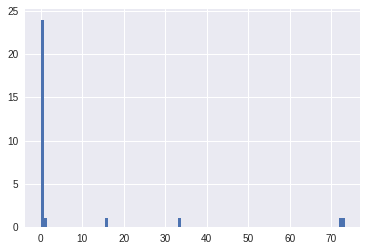

In [580]:
plt.hist(raw_technical_covariates.std(axis=0),bins=100)
plt.show()

Take the first 20 PCs of the expression matrix.

We would like to investigate how including these known technical covariates impact the analysis. 

In [ ]:
pvalue_results = {}

In [ ]:
pvalue_results = {}

1. No cov parameter
2. 29 technical factors as cov parameter
3. 20 PC components as cov parameter
4. 20 PCs + 29 technical factors as cov parameter

In [600]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_expression = pca.fit_transform(expression)

In [846]:
pca_covariates.shape

(231, 21)

In [844]:
np.hstack([pca_covariates, raw_technical_covariates]).shape

(231, 50)

In [678]:
from limix.qtl import qtl_test_lmm
from limix.plot import qqplot

pca_covariates = np.ones((sum(technical_idx),21))
pca_covariates[:,1:] = pca_expression[technical_idx]

technical_pvalues = {}
technical_and_pca_pvalues = {}
raw_pvalues = {}
pca_pvalues = {}

for f in range(100):
    single_feature = filt_tech_features[:,f].copy()
    technical_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float),covs=raw_technical_covariates)
    pca_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float),covs=pca_covariates)
    technical_and_pca_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float),covs=np.hstack([pca_covariates, raw_technical_covariates]))
    raw_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float))
    
    t_pvalues = technical_res.getPv().flatten()
    r_pvalues = raw_res.getPv().flatten()
    tp_pvalues = technical_and_pca_res.getPv().flatten()
    p_pvalues = pca_res.getPv().flatten()

    
    technical_pvalues[f] = t_pvalues
    raw_pvalues[f] = r_pvalues
    pca_pvalues[f] = p_pvalues
    technical_and_pca_pvalues[f] = tp_pvalues
    
    if f % 10 == 0:
        print (f,estimate_lambda(r_pvalues),estimate_lambda(t_pvalues), estimate_lambda(p_pvalues), estimate_lambda(tp_pvalues) )

0 3.73688944142 1.36613025456 1.80748845551 2.44427865077
10 10.7134964061 4.85926910717 1.78892463032 2.2352341152
20 6.50071041449 2.17914364798 2.47411391018 2.32712941172
30 4.73560429028 1.65691255132 2.46887640124 2.72839904426
40 8.62348542576 4.10333518817 1.54183282284 1.54295547312
50 1.55795154534 1.80363968436 1.1368550962 1.44246229062
60 8.95118358183 3.8284880359 2.74818135065 2.66668328236
70 9.35435673122 3.71166452752 1.59707094936 1.75258668597
80 3.26833717286 2.32122236038 2.41168137505 2.83900991922
90 7.507732478 1.78325311987 3.33953467138 2.46586508977


In [682]:
full_technical_pvalues = []
full_technical_and_pca_pvalues = []
full_raw_pvalues = []
full_pca_pvalues = []

for f in range(100):
    full_technical_pvalues.extend(technical_pvalues[f].tolist())
    full_raw_pvalues.extend(raw_pvalues[f].tolist())
    full_pca_pvalues.extend(pca_pvalues[f].tolist())
    full_technical_and_pca_pvalues.extend(technical_and_pca_pvalues[f].tolist())

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


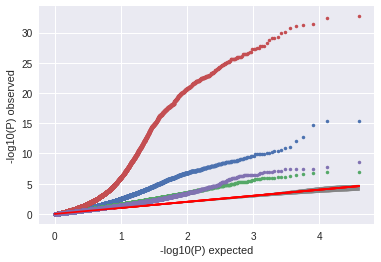

In [759]:
qqplot(np.array(full_technical_pvalues))
qqplot(np.array(full_technical_and_pca_pvalues))
qqplot(np.array(full_raw_pvalues))
qqplot(np.array(full_pca_pvalues))

Calculating p-values using lim with using different covariance sets:
* red - raw. $\lambda = 4.71$
* blue - 29 technical factors. $\lambda = 2.57$
* green - 20 PC componenets. $\lambda = 1.53$
* purple - 20 PCs + 29 technical factors. $\lambda = 1.76$

In [790]:
print (estimate_lambda(np.array(full_raw_pvalues)[np.array(full_raw_pvalues) < 1]))
print (estimate_lambda(np.array(full_technical_pvalues)[np.array(full_technical_pvalues) < 1]))
print (estimate_lambda(np.array(full_pca_pvalues)[np.array(full_pca_pvalues) < 1]))
print (estimate_lambda(np.array(full_technical_and_pca_pvalues)[np.array(full_technical_and_pca_pvalues) < 1]))

5.08505917487
2.75811323967
1.61946494585
1.87844375679


In [791]:
print (sum(smm.multipletests(np.array(full_raw_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (sum(smm.multipletests(np.array(full_technical_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (sum(smm.multipletests(np.array(full_pca_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (sum(smm.multipletests(np.array(full_technical_and_pca_pvalues),method='fdr_bh',alpha=0.01)[0]))


4323
1357
104
77


In [850]:
print (sum(smm.multipletests(np.array(full_raw_pvalues),method='bonf',alpha=0.01)[0]))
print (sum(smm.multipletests(np.array(full_technical_and_pca_pvalues),method='bonf',alpha=0.01)[0]))

1907
6


We can see that the much of the inflation disappears when using the first 20 PCs as covariates. There is not much difference when then including the technical factors.

# How does this change when using different numbers of PCs?

In [606]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_expression = pca.fit_transform(expression)

pca_covariates = np.ones(shape=(len(phenotype_idx),21))
pca_covariates[:,1:] = pca_expression

In [851]:
print (pca_covariates.shape)

(231, 21)


In [608]:
from limix.qtl import qtl_test_lmm
lambdas = []
full_pvalues = {}
for pc in range(20):
    pca_pvalues = {}

    for f in range(100):
        single_feature = filt_features[:,f].copy()
        
        pca_res = qtl_test_lmm(single_feature, filt_expression.astype(float),covs=pca_covariates[:,:pc+1])
        p_pvalues = pca_res.getPv().flatten()
        pca_pvalues[f] = p_pvalues


    full_pca_pvalues = []
    for f in range(100):
        full_pca_pvalues.extend(pca_pvalues[f].tolist())
    lamb = estimate_lambda(full_pca_pvalues)
    lambdas.append(lamb)
    full_pvalues[pc] = full_pca_pvalues 
    print (pc,lamb)

0 2.61011822323
1 2.45640707069
2 2.35283520603
3 1.72723805151
4 1.76075013684
5 1.65674416009
6 1.67749756037
7 1.72823053394
8 1.68459614238
9 1.71881789142
10 1.60821788616
11 1.63787424924
12 1.53902719261
13 1.53092602898
14 1.50275431314
15 1.47314213856
16 1.48789357744
17 1.4380809707
18 1.47569962002
19 1.51882083761


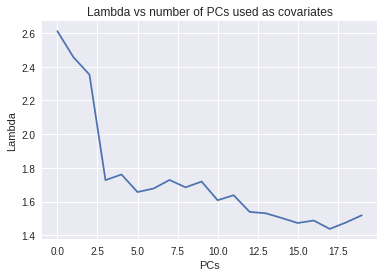

In [610]:
plt.plot(lambdas)
plt.title("Lambda vs number of PCs used as covariates")
plt.xlabel("PCs")
plt.ylabel("Lambda")

There seems to be a minimum at 20 PCs with lambda ~ 1.

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


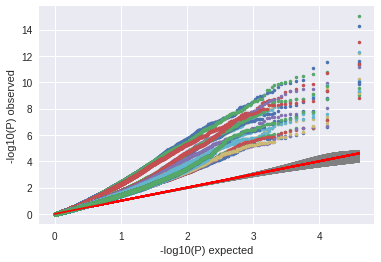

In [611]:
for pc in range(20):
    qqplot(np.array(full_pvalues[pc]))

1. No cov parameter
2. 29 technical factors as cov parameter
3. 20 PC components as cov parameter
4. 20 PCs + 29 technical factors as cov parameter

In [600]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_expression = pca.fit_transform(expression)

In [846]:
pca_covariates.shape

(231, 21)

In [844]:
np.hstack([pca_covariates, raw_technical_covariates]).shape

(231, 50)

In [678]:
from limix.qtl import qtl_test_lmm
from limix.plot import qqplot

pca_covariates = np.ones((sum(technical_idx),21))
pca_covariates[:,1:] = pca_expression[technical_idx]

technical_pvalues = {}
technical_and_pca_pvalues = {}
raw_pvalues = {}
pca_pvalues = {}

for f in range(100):
    single_feature = filt_tech_features[:,f].copy()
    technical_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float),covs=raw_technical_covariates)
    pca_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float),covs=pca_covariates)
    technical_and_pca_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float),covs=np.hstack([pca_covariates, raw_technical_covariates]))
    raw_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float))
    
    t_pvalues = technical_res.getPv().flatten()
    r_pvalues = raw_res.getPv().flatten()
    tp_pvalues = technical_and_pca_res.getPv().flatten()
    p_pvalues = pca_res.getPv().flatten()

    
    technical_pvalues[f] = t_pvalues
    raw_pvalues[f] = r_pvalues
    pca_pvalues[f] = p_pvalues
    technical_and_pca_pvalues[f] = tp_pvalues
    
    if f % 10 == 0:
        print (f,estimate_lambda(r_pvalues),estimate_lambda(t_pvalues), estimate_lambda(p_pvalues), estimate_lambda(tp_pvalues) )

0 3.73688944142 1.36613025456 1.80748845551 2.44427865077
10 10.7134964061 4.85926910717 1.78892463032 2.2352341152
20 6.50071041449 2.17914364798 2.47411391018 2.32712941172
30 4.73560429028 1.65691255132 2.46887640124 2.72839904426
40 8.62348542576 4.10333518817 1.54183282284 1.54295547312
50 1.55795154534 1.80363968436 1.1368550962 1.44246229062
60 8.95118358183 3.8284880359 2.74818135065 2.66668328236
70 9.35435673122 3.71166452752 1.59707094936 1.75258668597
80 3.26833717286 2.32122236038 2.41168137505 2.83900991922
90 7.507732478 1.78325311987 3.33953467138 2.46586508977


In [682]:
full_technical_pvalues = []
full_technical_and_pca_pvalues = []
full_raw_pvalues = []
full_pca_pvalues = []

for f in range(100):
    full_technical_pvalues.extend(technical_pvalues[f].tolist())
    full_raw_pvalues.extend(raw_pvalues[f].tolist())
    full_pca_pvalues.extend(pca_pvalues[f].tolist())
    full_technical_and_pca_pvalues.extend(technical_and_pca_pvalues[f].tolist())

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


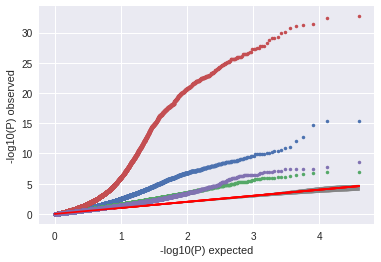

In [759]:
qqplot(np.array(full_technical_pvalues))
qqplot(np.array(full_technical_and_pca_pvalues))
qqplot(np.array(full_raw_pvalues))
qqplot(np.array(full_pca_pvalues))

Calculating p-values using lim with using different covariance sets:
* red - raw. $\lambda = 4.71$
* blue - 29 technical factors. $\lambda = 2.57$
* green - 20 PC componenets. $\lambda = 1.53$
* purple - 20 PCs + 29 technical factors. $\lambda = 1.76$

In [790]:
print (estimate_lambda(np.array(full_raw_pvalues)[np.array(full_raw_pvalues) < 1]))
print (estimate_lambda(np.array(full_technical_pvalues)[np.array(full_technical_pvalues) < 1]))
print (estimate_lambda(np.array(full_pca_pvalues)[np.array(full_pca_pvalues) < 1]))
print (estimate_lambda(np.array(full_technical_and_pca_pvalues)[np.array(full_technical_and_pca_pvalues) < 1]))

5.08505917487
2.75811323967
1.61946494585
1.87844375679


In [791]:
print (sum(smm.multipletests(np.array(full_raw_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (sum(smm.multipletests(np.array(full_technical_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (sum(smm.multipletests(np.array(full_pca_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (sum(smm.multipletests(np.array(full_technical_and_pca_pvalues),method='fdr_bh',alpha=0.01)[0]))


4323
1357
104
77


In [850]:
print (sum(smm.multipletests(np.array(full_raw_pvalues),method='bonf',alpha=0.01)[0]))
print (sum(smm.multipletests(np.array(full_technical_and_pca_pvalues),method='bonf',alpha=0.01)[0]))

1907
6


We can see that the much of the inflation disappears when using the first 20 PCs as covariates. There is not much difference when then including the technical factors.

# How does this change when using different numbers of PCs?

In [606]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_expression = pca.fit_transform(expression)

pca_covariates = np.ones(shape=(len(phenotype_idx),21))
pca_covariates[:,1:] = pca_expression

In [851]:
print (pca_covariates.shape)

(231, 21)


In [608]:
from limix.qtl import qtl_test_lmm
lambdas = []
full_pvalues = {}
for pc in range(20):
    pca_pvalues = {}

    for f in range(100):
        single_feature = filt_features[:,f].copy()
        
        pca_res = qtl_test_lmm(single_feature, filt_expression.astype(float),covs=pca_covariates[:,:pc+1])
        p_pvalues = pca_res.getPv().flatten()
        pca_pvalues[f] = p_pvalues


    full_pca_pvalues = []
    for f in range(100):
        full_pca_pvalues.extend(pca_pvalues[f].tolist())
    lamb = estimate_lambda(full_pca_pvalues)
    lambdas.append(lamb)
    full_pvalues[pc] = full_pca_pvalues 
    print (pc,lamb)

0 2.61011822323
1 2.45640707069
2 2.35283520603
3 1.72723805151
4 1.76075013684
5 1.65674416009
6 1.67749756037
7 1.72823053394
8 1.68459614238
9 1.71881789142
10 1.60821788616
11 1.63787424924
12 1.53902719261
13 1.53092602898
14 1.50275431314
15 1.47314213856
16 1.48789357744
17 1.4380809707
18 1.47569962002
19 1.51882083761


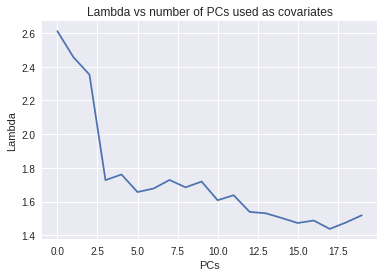

In [610]:
plt.plot(lambdas)
plt.title("Lambda vs number of PCs used as covariates")
plt.xlabel("PCs")
plt.ylabel("Lambda")

There seems to be a minimum at 20 PCs with lambda ~ 1.

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


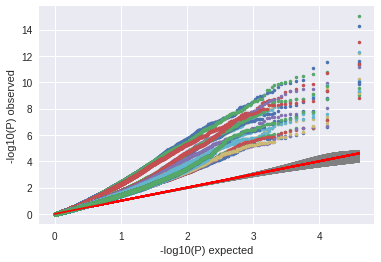

In [611]:
for pc in range(20):
    qqplot(np.array(full_pvalues[pc]))

In [ ]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import numpy as np
from limix.plot import qqplot
import warnings
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import gzip
import pandas as pd

mean_features = {}
with h5py.File(GTEx_directory + '/data/intermediate/new_retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    donor_IDs = f['lung']['256']['donor_IDs'].value
    for s in ['128','256','512','1024','2048']:
        size_mean_features = f['lung'][s]['mean'].value
        mean_features[s] = size_mean_features
        
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))

filt_expression = expression[:,most_expressed_transcript_idx]
filt_features = mean_features['256'][:,most_varying_feature_idx]

phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
with gzip.open(phenotype_filepath, 'rb') as f:
    phenotype_array = [str(x, 'utf-8').split('\t') for x in f.read().splitlines() if not str(x, 'utf-8').startswith('#')][1:]
    phenotype_df = pd.DataFrame(phenotype_array)
    phenotype_df.columns = phenotype_df.iloc[0]
    phenotype_df = phenotype_df[1:]

lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
phenotype_idx = [[x.split('-')[1] for x in lung_df['SAMPID']].index(ID) for ID in [x.decode('utf-8').split('-')[1] for x in donor_IDs]]


lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
lung_df = lung_df.iloc[phenotype_idx,:]

filt_tech_expression =  filt_expression[technical_idx,:]
filt_tech_features =  filt_features[technical_idx,:]
print ("Filtered technical features:")
print (filt_tech_expression.shape, filt_tech_features.shape)
